In [449]:
# imports
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

K=10

In [450]:
# plotting 
# Pictures 1x10
def plotPictures(trained_Weight, safeto, row, col, save=False):
    s_im =[]
    for label in range(trained_Weight.shape[0]):
        im =  np.transpose(np.reshape(trained_Weight[label, :], (3, 32,32)), (1,2,0))
        im = (im - im.min()) / (im.max() - im.min())
        s_im.append(im)

    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(row, col),  # creates 1x10 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, s_im):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
    if save:
        plt.savefig(safeto)
    plt.show()

# plot all graphs
def plotResults(costs_train, accs_train, costs_validate, accs_validate, W, safeto, save=False):
    # plotting costs
    plt.plot(costs_train, label = "training")
    plt.plot(costs_validate, label = "validation")
    plt.xlabel('n_epochs')
    plt.ylabel('cost')
    plt.suptitle('Cost')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/'+safeto+'cost.png')
    plt.show()  
    
    # plotting accuracy
    plt.plot(accs_train, label = 'training')
    plt.plot(accs_validate, label = 'validation')
    plt.xlabel('n_epochs')
    plt.ylabel('accuracy')
    plt.suptitle('Accuracy')
    plt.legend()
    if save:
        plt.savefig('Result_Pics/'+safeto+'acc.png')
    plt.show()
    
    # plotting pictures from W
    plotPictures(W, 'Result_Pics/'+safeto+'weights.png', 2,5, save)


In [451]:
'''Given from template.
Translated form Matlab to Python in the course
    '''

def ComputeGradsNum(X, Y, P, W, b, lamda, h):
    """ Converted from matlab code """
    no    =     W.shape[0]
    d     =     X.shape[0]
    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));
    c = ComputeCost(X, Y, W, b, lamda);
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] += h
        c2 = ComputeCost(X, Y, W, b_try, lamda)
        grad_b[i] = (c2-c) / h
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.array(W)
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lamda)
            grad_W[i,j] = (c2-c) / h
    return [grad_W, grad_b]
            
            
def ComputeGradsNumSlow(X, Y, P, W, b, lamda, h):
    """ Converted from matlab code """
    no    =     W.shape[0]
    d     =     X.shape[0]
    grad_W = np.zeros(W.shape);
    grad_b = np.zeros((no, 1));
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] -= h
        c1 = ComputeCost(X, Y, W, b_try, lamda)
        b_try = np.array(b)
        b_try[i] += h
        c2 = ComputeCost(X, Y, W, b_try, lamda)
        grad_b[i] = (c2-c1) / (2*h)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.array(W)
            W_try[i,j] -= h
            c1 = ComputeCost(X, Y, W_try, b, lamda)
            W_try = np.array(W)
            W_try[i,j] += h
            c2 = ComputeCost(X, Y, W_try, b, lamda)
            grad_W[i,j] = (c2-c1) / (2*h)
    return [grad_W, grad_b]

In [595]:
# Exercise 1: Trainin a multi-linear classifier
#functions
# 1. LoadBatch reads reads in the data from a CIFAR-10 batch file and returns the image and label data in separate files
'''
X: image pixel data, has size dxn (3072x10000), is of type double or single and has entries between 0 and 1. 
n: Number of images. here 1000
d: dimensionality of each image(3072=32x32x3)
Y: is Kxn (K= # of labels = 10) and contains the one-hot representation of the label for each image.
y:  is a vector of length n containing the label for each image.
OneHotEncoder: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
'''
def LoadBatch(filename):
    matdata  = sio.loadmat(filename)
    X_images = np.matrix(matdata['data']).astype(float)
    y_labels = np.array(matdata['labels'])
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_onehot = onehot_encoder.fit_transform(y_labels).astype(int)
    return X_images.T,Y_onehot.T,y_labels.T # convert to (dxn)

# 2. Pre-process
'''
mean_X: (dx1) (3072x1)
std_X: (dx1) (3072x1)
standardize: x = (x-mean)/std
'''
def standardize(X):
    mean_X = X.mean(axis=1)
    std_X = X.std(axis=1)
    X_standarrdized = (X - mean_X) / std_X
    return X_standarrdized

# 3. Initialize parameters
def initialize(mean, std, X):
    W = np.random.normal(mean, std, (K,X.shape[0])) 
    b = np.random.normal(mean, std, (K,1)) 
    return W,b

def initialize_xavier(mean,std, X):
    W = np.random.normal(mean, (2/np.sqrt(X.shape[1])), (K,X.shape[0])) 
    b = np.random.normal(mean, std, (K,1)) 
    return W,b

# 4. EvaluateClassifier function that evaluates the network function
'''
X: each column of X corresponds to an image and it has size dxn.
W, b: W and b are the parameters of the network.
P: each column of P contains the probability for each label for the image 
in the corresponding column of X. P has size Kxn (10x10000).'''

def EvaluateClassifier(X,W,b):
    s = W*X+b
    return softmax(s)

def softmax(scores):
    return np.exp(scores)/np.sum(np.exp(scores), axis=0)

# 5. Compute cost function
'''
X: each column of X corresponds to an image and X has size dxn.
Y: each column of Y (Kxn) is the one-hot ground truth label for the 
corresponding column of X or Y is the (1xn) vector of ground truth labels.
J: J is a scalar corresponding to the sum of the loss of the network's
predictions for the images in X relative to the ground truth labels and
the regularization term on W.
'''

def ComputeCost(X, Y, W, b, lam):  
    J =  np.sum(LossCrossEntropy(X,Y,W,b))/X.shape[1] +  lam * np.sum(np.square(W))
    return J
    
def LossCrossEntropy(X,Y,W,b):
    p = EvaluateClassifier(X,W,b)
    Y = np.reshape(Y, (K, p.shape[1]))
    return - np.log(np.multiply(Y, p).sum(axis=0))

# 6. computes the accuracy of the network's predictions on a set of data.
'''
X: each column of X corresponds to an image and X has size dxn.
y: y is the vector of ground truth labels of length n.
acc: acc is a scalar value containing the accuracy.
'''
def ComputeAccuracy(X, y, W, b):
    p = EvaluateClassifier(X,W,b)
    pred = np.argmax(p, axis=0)
    acc =  np.count_nonzero(pred == y) / X[1].size
    return acc

# 7. function that evaluates, for a mini-batch, the gradients of the cost function w.r.t. W and b
'''
X: each column of X corresponds to an image and it has size dxn.
Y: each column of Y (Kxn) is the one-hot ground truth label for the corresponding column of X.
P: each column of P contains the probability for each label for the image in the corresponding column of X. P has size Kxn.
grad_W: grad_W is the gradient matrix of the cost J relative to W and has size Kxd.   
'''

def ComputeGradients(X, Y, W, lam):
    P = EvaluateClassifier(X,W,b)
    Y = np.reshape(Y, (K, P.shape[1]))
    N = X[1].size 
    
    g_batch = -(Y-P)
    ones =  np.full((N,1), 1)

    grad_W = 1/N * g_batch * X.T + 2*lam*W
    grad_b = 1/N * g_batch * ones
    return grad_W, grad_b

def ComputeRelativeError(ga ,gn ,eps):
    return np.absolute(np.subtract(ga, gn))/np.maximum(np.add(np.absolute(ga), np.absolute(gn)), np.full(ga.shape, eps))

def testGradients(X,Y,W, lam):
    # Analytical gradients
    grad_W_ana, grad_b_ana = ComputeGradients(X, Y, W, lam)
    # Numerical gradients lambda = 0
    grad_W_num, grad_b_num = ComputeGradsNum(X, Y, P, W, b, lam, 1e-6)
    # slow but precise computation
    grad_W_num_slow, grad_b_num_slow = ComputeGradsNumSlow(X, Y, P, W, b, lam, 1e-6)
    # Compute the relative error and check if it is "small"
    relative_errors_b = ComputeRelativeError(grad_b_num ,grad_b_ana ,1e-6)   
    relative_errors_W = ComputeRelativeError(grad_W_num ,grad_W_ana ,1e-6)   
    print("Error for gradients for b smaller 1e-6: \n",np.max(relative_errors_b) < 1e-6)   
    print("Error for gradients for W smaller 1e-5: \n",np.max(relative_errors_W) )
    # slow version
    #relative_errors_b_slow = ComputeRelativeError(grad_b_num_slow ,grad_b_ana ,1e-6)
    #relative_errors_W_slow = ComputeRelativeError(grad_W_num_slow ,grad_W_ana ,1e-6)
    #print("Error for gradients for b smaller 1e-6 (slow verison): \n",relative_errors_b_slow < 1e-6)
    #print("Error for gradients for W smaller 1e-6 (slow version): \n",relative_errors_W_slow  < 1e-6)


# 8. Mini-batch gradient descent algorithm
'''
n_batch: the size of the mini-batches -> number of images in mini-batch
eta: learning rate
n_epochs: number of runs through the whole training set.'''

def GenerateMiniBatches(n_batch, X, Y, permute):
    n = X[1].size 
    X_batches = []
    Y_batches = []
    if permute:
        #X_sh, Y_sh = shuffle(X.T, Y.T) #causes memory error
        shuff_indx = np.random.permutation(X.shape[1])
        X = X[:, shuff_indx]
        Y = Y[:, shuff_indx]
    for j in range(int(n/n_batch)):
        j_start = j*n_batch 
        j_end = (j+1)*n_batch 
        
        X_batch = X[:, j_start:j_end]
        Y_batch = Y[:, j_start:j_end]
        
        X_batches.append(X_batch)
        Y_batches.append(Y_batch)
        
    return X_batches, Y_batches
 
# 8. Mini-batch functions
'''
X: all the training images
Y: labels for the training images
W,b: initial values for the network's parameters
lam: regularization factor in the cost function
'''
def MiniBatchGD(X, Y, y, X_validate, Y_validate, y_validate,  W, b, n_batch, eta, n_epochs, lam, permute, decay, update_round):
    costs_train = []
    accs_train = []
    costs_validate = []
    accs_validate  = []
    velocity = np.zeros_like(W)
    
    # compute cost -> print and save it  
    costs_train.append(ComputeCost(X, Y, W, b, lam))
    costs_validate.append(ComputeCost(X_validate, Y_validate, W, b, lam))
            
    # compute acc -> print and save it 
    accs_train.append(ComputeAccuracy(X, y, W, b))
    acc_validate = ComputeAccuracy(X_validate, y_validate, W, b)
    accs_validate.append(ComputeAccuracy(X_validate, y_validate, W, b))
    
    # bonus 1b
    acc_best = acc_validate
    n_best = 0
    
    if not permute:
        X_batches, Y_batches = GenerateMiniBatches(n_batch, X, Y, permute)
    for epoch in range(n_epochs): #iterate over epoch
        if permute:  # shuffle training data for every epoch
            X_batches, Y_batches = GenerateMiniBatches(n_batch, X, Y, permute)
        
        if (epoch > 0 and epoch%update_round == 0 and eta > eta_stop):
            eta *= decay # decay eta
        
        # iterate over mini-batches        
        for idx, X_batch in enumerate(X_batches, start=0):
            Y_batch = Y_batches[idx]
            # compute gradients for batch

            grad_W_ana, grad_b_ana = ComputeGradients(X_batch, Y_batch, W, lam) 
                # adjust W,b by eta
            W -= eta*grad_W_ana
            b -= eta*grad_b_ana
 
        cost_train = ComputeCost(X, Y, W, b, lam)
        cost_validate = ComputeCost(X_validate, Y_validate, W, b, lam)
        costs_train.append(cost_train)
        costs_validate.append(cost_validate)

        acc_train = ComputeAccuracy(X, y, W, b)
        accs_train.append(acc_train)
        acc_validate = ComputeAccuracy(X_validate, y_validate, W, b)
        accs_validate.append(acc_validate)
        print("epoch {0} \n cost_train: {1} \n cost_validate: {2} \n accuracy_train: {3} \n accuracy_validate: {4} \n".format(epoch, cost_train, cost_validate, acc_train, acc_validate))

                
        if acc_validate > acc_best: # bonus 1b
            W_best = W.copy()
            n_best = epoch
            acc_best = acc_validate

    return costs_train, accs_train, costs_validate, accs_validate, W, W_best, n_best

In [596]:
'''
Bonus 2: Train network by minimizing the SVM multi-class loss
Modified functions for SVM:

ComputeGradientsSVM_slow: iterative computation of loss and gradients using svm 
ComputeGradientsSVM: vectorized computation of gradients using svm loss
ComputeCostSVM: vectorized computation of loss using svm loss
testGradients_svm: compares values of vectorized with iterative version
GenerateMiniBatches_svm: generates X,Y,y batches
MiniBatchGD_svm: version of the miniBatch training using the functions for svm
'''

def ComputeGradientsSVM_slow(X, y, W, b, lam):
    # transpose and retranspose to match dim + row format of this exercise
    X = X.T
    W = W.T
    y = y.T
    b = b.T
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    
    for i in range(num_train):
        scores = X[i,:].dot(W)+b
        correct_class_score = scores[0,y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[0,j] - correct_class_score + 1 
            if margin > 0:
                loss += margin
                dW[:,y[i]] -= X[i,:].T
                dW[:,[j]] += X[i,:].T 
                db[0,y[i]] -=1
                db[0,j] +=1

  # Averaging over all examples
    loss /= num_train
    dW /= num_train
    db /= num_train

  # Add regularization (not sure which one to use)
    loss += 0.5*lam * np.sum(np.square(W))
    dW += 1*lam*W
    return loss.item(0), dW.T, db.T

def ComputeGradientsSVM(X, y, W, b, lam):
    # transpose and retranspose to match dim + row format of this exercise
    X = X.T
    W = W.T
    b = b.T
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape) 
    loss = 0.0
    num_train = X.shape[0]
    ones =  np.full((num_train,1), 1)
    
    scores = np.dot(X, W) + np.dot(ones, b)
    yi_scores = scores[np.arange(scores.shape[0]),y] # could also be done using Y_onehot
    margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)    
    margins[np.arange(num_train),y] = 0 # cancel out where yi = j
    binary = margins 
    binary[margins > 0] = 1 # indicator function suggests us to “binarize” this matrix 
    row_sum = np.sum(binary, axis=1) # update the binarized matrix by summing across each column 
    binary[np.arange(num_train), y] = -row_sum.T # taking the negative values, and assigning them to yi components with
    dW = np.dot(X.T, binary)/num_train
    db = np.dot(ones.T, binary)/num_train
    dW += 1*lam*W   # Regularize (not sure which one to use)
    return  dW.T, db.T

def ComputeCostSVM(X, y, W, b, lam):
    # transpose and retranspose to match dim + row format of this exercise
    X = X.T
    W = W.T
    b = b.T
    num_train = X.shape[0]
    ones =  np.full((num_train,1), 1)
    loss = 0.0
    
    scores = np.dot(X, W)+ np.dot(ones, b)
    yi_scores = scores[np.arange(scores.shape[0]),y] # we could also use Y_onehot
    margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)
    margins[np.arange(num_train),y] = 0 # cancel out where yi = j
    loss = np.mean(np.sum(margins, axis=1))
    loss += 0.5*lam * np.sum(np.square(W)) #(not sure which one to use)
    return loss 

def testGradients_svm(X,y,W,b,lam):
    # Vectorized gradients
    grad_W, grad_b = ComputeGradientsSVM(X, y, W, b, lam)
    # slow but precise computation
    loss_slow, grad_W_slow, grad_b_slow = ComputeGradientsSVM_slow(X, y, W, b, lam)
    # Compute the relative error and check if it is "small"
    relative_errors_b = ComputeRelativeError(grad_b ,grad_b_slow ,1e-6)
    relative_errors_W = ComputeRelativeError(grad_W ,grad_W_slow ,1e-6)
    print("Error for gradients for b smaller 1e-6: ",np.max(relative_errors_b) < 1e-6)
    print("Error for gradients for W smaller 1e-5: ",np.max(relative_errors_W) < 1e-5)
    
def GenerateMiniBatches_svm(n_batch, X, Y, y, permute):
    n = X[1].size 
    X_batches = []
    Y_batches = []
    y_batches = []
    if permute:
        #X_sh, Y_sh = shuffle(X.T, Y.T) #causes memory error
        shuff_indx = np.random.permutation(X.shape[1])
        X = X[:, shuff_indx]
        Y = Y[:, shuff_indx]
        y = y[:,shuff_indx]
        
    for j in range(int(n/n_batch)):
        j_start = j*n_batch 
        j_end = (j+1)*n_batch 
        
        X_batch = X[:, j_start:j_end]
        Y_batch = Y[:, j_start:j_end]
        y_batch = y[:, j_start:j_end]

        X_batches.append(X_batch)
        Y_batches.append(Y_batch)
        y_batches.append(y_batch)
        
    return X_batches, Y_batches, y_batches
 
def MiniBatchGD_svm(X, Y, y, X_validate, Y_validate, y_validate,  W, b, n_batch, eta,n_epochs, lam, permute, decay):
    costs_train = []
    accs_train = []
    costs_validate = []
    accs_validate  = []
    velocity = np.zeros_like(W)
  
    
    # compute cost -> print and save it  
    costs_train.append(ComputeCostSVM(X, y, W, b, lam))
    costs_validate.append(ComputeCostSVM(X_validate, y_validate, W, b, lam))
            
    # compute acc -> print and save it 
    accs_train.append(ComputeAccuracy(X, y, W, b))
    acc_validate = ComputeAccuracy(X_validate, y_validate, W, b)
    accs_validate.append(acc_validate)
    
    # bonus 1b
    acc_best = acc_validate
    n_best = 0
    
    if not permute:
        X_batches, Y_batches, y_batches = GenerateMiniBatches_svm(n_batch, X, Y, y, permute)
        
    for epoch in range(n_epochs): #iterate over epochs        
        if permute: # shuffle training data for every epoch
            X_batches, Y_batches, y_batches = GenerateMiniBatches_svm(n_batch, X, Y,y, permute)
            
        eta *= decay # decay eta
        
        # iterate over mini-batches        
        for idx, X_batch in enumerate(X_batches, start=0):
            y_batch = y_batches[idx]
            grad_W_svm, grad_b_svm = ComputeGradientsSVM(X_batch, y_batch, W, b, lam)
            # adjust W,b by eta
            W -= eta*grad_W_svm
            b -= eta*grad_b_svm

        # compute cost -> print and save it    
        cost_train = ComputeCostSVM(X, y, W, b, lam)
        cost_validate = ComputeCostSVM(X_validate, y_validate, W, b, lam)
        costs_train.append(cost_train)
        costs_validate.append(cost_validate)
            
        # compute acc -> print and save it
        acc_train = ComputeAccuracy(X, y, W, b)
        accs_train.append(acc_train)
        acc_validate = ComputeAccuracy(X_validate, y_validate, W, b)
        accs_validate.append(acc_validate)
        
        print("epoch {0} \n cost_train: {1} \n cost_validate: {2} \n accuracy_train: {3} \n accuracy_validate: {4} \n".format(epoch, cost_train, cost_validate, acc_train, acc_validate))

                
        if acc_validate > acc_best: # bonus 1b
            W_best = W.copy()
            n_best = epoch
            acc_best = acc_validate

    return costs_train, accs_train, costs_validate, accs_validate, W, W_best, n_best

In [597]:
# 0. Set the parameters
# Parameters
regularization = 0.1
n_epochs = 100
n_batch = 100
eta = 0.03
permute = True
setup = "test"
# only for setup7alldata
alldata = True
train_size = 49000
#decaying
decay = 0.9
update_round = 2
eta_stop = 0.0005
# xavier init
xavier = False
# svm
svm = False


# 1. Read in and store the training, validation and test data.
print("PART 1: LOAD DATA")
if alldata:
    for setnum in range(5):
        path = 'Dataset/cifar-10-batches-mat/data_batch_'+str(setnum+1)+'.mat'
        (X_images_current,Y_onehot_current,y_labels_current)= LoadBatch(path)
        if setnum == 0:
            X_images_all = X_images_current
            Y_onehot_all = Y_onehot_current
            y_labels_all = y_labels_current
        else:
            X_images_all = np.append(X_images_all, X_images_current, 1)
            Y_onehot_all = np.append(Y_onehot_all, Y_onehot_current, 1)
            y_labels_all = np.append(y_labels_all, y_labels_current, 1)
    # split into train and validate
    X_images_train = X_images_all[:, 0:train_size]
    X_images_validate = X_images_all[:, train_size:]
    Y_onehot_train = Y_onehot_all[:, 0:train_size]
    Y_onehot_validate = Y_onehot_all[:, train_size:]
    y_labels_train = y_labels_all[:, 0:train_size]
    y_labels_validate = y_labels_all[:, train_size:]
else:
    (X_images_train,Y_onehot_train,y_labels_train)= LoadBatch('Dataset/cifar-10-batches-mat/data_batch_1.mat')
    (X_images_validate,Y_onehot_validate,y_labels_validate)= LoadBatch('Dataset/cifar-10-batches-mat/data_batch_2.mat')
    (X_images_test,Y_onehot_test,y_labels_test)= LoadBatch('Dataset/cifar-10-batches-mat/test_batch.mat')

# Check the shapes and forms of the loaded data
'''
X (3072x10000) row x column
Y (10x10000)
y (1x10000)
''' 
print("Shapes of loaded data: \n",X_images_train.shape, Y_onehot_train.shape, y_labels_train.shape)
# check one hot encoding structure
print("\nOne hot encoded structure: \n",y_labels_train[:,0], Y_onehot_train[:,0])

# 2. Pre-process
print("\nPART 2: PRE-PROCESS")
X_images_train= standardize(X_images_train)
X_images_validate= standardize(X_images_validate)
X_images_test= standardize(X_images_test)

# check if mean is zero (very small)
mean_X_zero = X_images_train.mean(axis=1)
print("Zero mean values: \n",np.max(mean_X_zero))
std_X_one = X_images_train.std(axis=1)
print("Std values: \n",np.max(std_X_one))

# 3. Initialize parameters W and b
print("\nPART 3: INITIALIZE PARAMETERS")
'''
W: Kxd (10x3072)
b: Kx1 (10x1)
'''
if xavier:
    W,b = initialize_xavier(0.0, 0.01, X_images_train)
else:
    W,b = initialize(0.0, 0.01, X_images_train)
    
print("Shapes of W and b: \n",W.shape,b.shape)

#4. Evaluate classifiers
print("\nPART 4: COMPUTE PROBABILITIES")
P = EvaluateClassifier(X_images_train, W,b)

print("Shape of P: \n",P.shape)
print("\nSum of probabilites for the first image: \n",np.sum(P[:,0]))

#5. Compute cost 
print("\nPART 5: COMPUTE COST")
J = ComputeCost(X_images_train, Y_onehot_train, W, b, 0)

print("Initial cost with lambda = 0: \n",J)

#6. compute accuracy
print("\nPART 6: COMPUTE ACCURACY")
acc = ComputeAccuracy(X_images_train, y_labels_train, W, b)

print("Initial accuracy of predicions: \n",acc)

#7 compute gradients 
print("\nPART 7: COMPUTE AND TEST GRADIENTS")
   
#5. Compute cost 
if svm: 
    print("Test: Compare SVM slow and vectorized computation")
    testGradients_svm(X_images_train, y_labels_train, W, b, regularization)
else:
    print("Test: Using one picture")
    #testGradients(X_images_train[:, 1], Y_onehot_train[:, 1], W, regularization)

    print("\nTest2: One picture and reduced dimensionality")
    #testGradients(X_images_train[0:20, 1], Y_onehot_train[0:20, 1], W[:, 0:20], regularization)

PART 1: LOAD DATA
Shapes of loaded data: 
 (3072, 49000) (10, 49000) (1, 49000)

One hot encoded structure: 
 [6] [0 0 0 0 0 0 1 0 0 0]

PART 2: PRE-PROCESS
Zero mean values: 
 2.65911782389246e-15
Std values: 
 1.0000000000005413

PART 3: INITIALIZE PARAMETERS
Shapes of W and b: 
 (10, 3072) (10, 1)

PART 4: COMPUTE PROBABILITIES
Shape of P: 
 (10, 49000)

Sum of probabilites for the first image: 
 1.0000000000000002

PART 5: COMPUTE COST
Initial cost with lambda = 0: 
 2.523185829435683

PART 6: COMPUTE ACCURACY
Initial accuracy of predicions: 
 0.08081632653061224

PART 7: COMPUTE AND TEST GRADIENTS
Test: Using one picture

Test2: One picture and reduced dimensionality



PART 8: TRAINING ON MINI BATCHES
epoch 0 
 cost_train: 2.411666057828767 
 cost_validate: 2.4028216911771647 
 accuracy_train: 0.30887755102040815 
 accuracy_validate: 0.335 

epoch 1 
 cost_train: 2.391030258956343 
 cost_validate: 2.3928675556698487 
 accuracy_train: 0.3034081632653061 
 accuracy_validate: 0.311 

epoch 2 
 cost_train: 2.564722422324003 
 cost_validate: 2.596536319783731 
 accuracy_train: 0.30157142857142855 
 accuracy_validate: 0.302 

epoch 3 
 cost_train: 2.467082331457604 
 cost_validate: 2.439204817082172 
 accuracy_train: 0.3090612244897959 
 accuracy_validate: 0.305 

epoch 4 
 cost_train: 2.0095897812560732 
 cost_validate: 2.0071538409117786 
 accuracy_train: 0.3399795918367347 
 accuracy_validate: 0.355 

epoch 5 
 cost_train: 2.27230337709681 
 cost_validate: 2.3333084205447916 
 accuracy_train: 0.30683673469387757 
 accuracy_validate: 0.313 

epoch 6 
 cost_train: 2.074605961709351 
 cost_validate: 2.1554753048604525 
 accuracy_train: 0.3210408163265306 

epoch 57 
 cost_train: 1.7622536577753454 
 cost_validate: 1.8011592562071221 
 accuracy_train: 0.4220204081632653 
 accuracy_validate: 0.414 

epoch 58 
 cost_train: 1.7612839881311888 
 cost_validate: 1.8042048714401397 
 accuracy_train: 0.42128571428571426 
 accuracy_validate: 0.412 

epoch 59 
 cost_train: 1.7618394567861502 
 cost_validate: 1.8033179684635356 
 accuracy_train: 0.42412244897959184 
 accuracy_validate: 0.414 

epoch 60 
 cost_train: 1.7607070999174155 
 cost_validate: 1.8051222434108665 
 accuracy_train: 0.42248979591836733 
 accuracy_validate: 0.422 

epoch 61 
 cost_train: 1.7605519146921962 
 cost_validate: 1.8008565156393812 
 accuracy_train: 0.42236734693877553 
 accuracy_validate: 0.411 

epoch 62 
 cost_train: 1.7617513719409557 
 cost_validate: 1.8004067914755622 
 accuracy_train: 0.42028571428571426 
 accuracy_validate: 0.413 

epoch 63 
 cost_train: 1.7608653322825447 
 cost_validate: 1.8035408117811373 
 accuracy_train: 0.4249183673469388 
 accuracy_valid

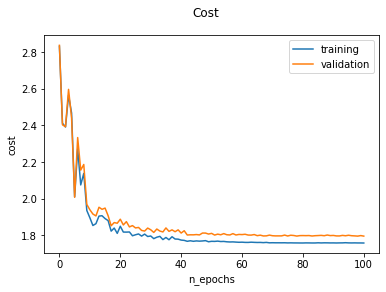

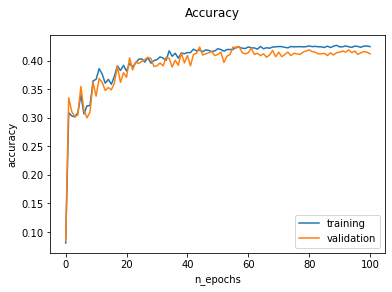

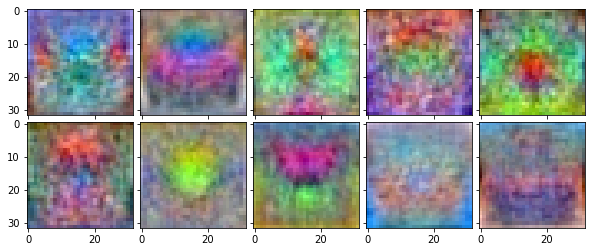

PART 10: ACCURACY ON TEST DATASET

test accuracy W:  0.4116
test accuracy best:  0.4052 56


In [598]:
# 8 Training
print("\nPART 8: TRAINING ON MINI BATCHES")
if svm:
    costs_train, accs_train, costs_validate, accs_validate, W_trained, W_best, n_best  = MiniBatchGD_svm(X_images_train, Y_onehot_train, y_labels_train, X_images_validate, Y_onehot_validate, y_labels_validate, W, b, n_batch, eta, n_epochs, regularization, permute, decay)
else:
    costs_train, accs_train, costs_validate, accs_validate, W_trained, W_best, n_best  = MiniBatchGD(X_images_train, Y_onehot_train, y_labels_train, X_images_validate, Y_onehot_validate, y_labels_validate, W, b, n_batch, eta, n_epochs, regularization, permute, decay, update_round)

# 9 Plotting the resuts
print("\n PART 9: PLOTTING RESULTS\n")
plotResults(costs_train, accs_train, costs_validate, accs_validate, W_trained, setup, True)

# 10 Accuracy on test data
print("PART 10: ACCURACY ON TEST DATASET\n")
acc_test = ComputeAccuracy(X_images_test, y_labels_test, W_trained, b)
acc_test_best = ComputeAccuracy(X_images_test, y_labels_test, W_best, b)
print("test accuracy W: ",acc_test)
print("test accuracy best: ",acc_test_best, n_best)